# Exercise 1

In [1]:
from bandit import Bandit
from algorithms import ETCAgent
from tqdm import tqdm 
import time 
import numpy as np
import matplotlib.pyplot as plt

# fix seed for reproducibility
np.random.seed(42)

K = 10
horizon = 10_000
m_values = [100, 500, 700]
# m_values = [50]
num_simulations = 100



In [2]:
def simulate(bandit, agent, horizon: int) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    """
    Simulates interaction between bandit and agent.

    Returns:
        rewards: Array of obtained rewards.
        regret: Array of cumulative regret.
        optimal_choices: Binary array indicating if optimal arm was chosen.
    """
    rewards = np.zeros(horizon)
    regret = np.zeros(horizon)
    optimal_choices = np.zeros(horizon)
    optimal_arm = np.argmax(bandit.means)
    optimal_mean = bandit.means[optimal_arm]
    estimates = []
    for t in range(horizon):
        arm = agent.select_arm()
        reward = bandit.perform_action(arm)
        agent.update(arm, reward)

        rewards[t] = reward
        regret[t] = (optimal_mean - bandit.means[arm]) if bandit.dist_type == 'gaussian' else 0.0
        optimal_choices[t] = 1 if arm == optimal_arm else 0
        estimates.append(agent.values.copy())

        if t > 0:
            regret[t] += regret[t - 1]  # Cumulative regret

    return rewards, regret, optimal_choices, estimates

In [3]:
etc_results = {m: {'regret': [], 'optimal': []} for m in m_values}
estimates_over_time = {m: [] for m in m_values}
actual_means = {m: [] for m in m_values}

for m in m_values:
    print(f"Running simulations for ETC (m = {m})")
    bandit = Bandit(K=K, dist_type='gaussian')
    actual_means[m].append(bandit.means)
    # for _ in tqdm(range(num_simulations)):
    for _ in tqdm(range(num_simulations)):
    
        agent = ETCAgent(K=K, m=m, horizon=horizon)
        _, regret, optimal_choices, estimates = simulate(bandit, agent, horizon)
        etc_results[m]['regret'].append(regret)
        etc_results[m]['optimal'].append(optimal_choices)
        estimates_over_time[m].append(estimates)
    estimates_over_time[m] = np.array(estimates_over_time[m])
    etc_results[m]['optimal'] = np.array(etc_results[m]['optimal'])
    actual_means[m] = np.array(actual_means[m][0])



Running simulations for ETC (m = 100)


100%|██████████| 100/100 [00:01<00:00, 63.77it/s]


Running simulations for ETC (m = 500)


100%|██████████| 100/100 [00:01<00:00, 62.48it/s]


Running simulations for ETC (m = 700)


100%|██████████| 100/100 [00:01<00:00, 60.69it/s]


## Cumulative Regret

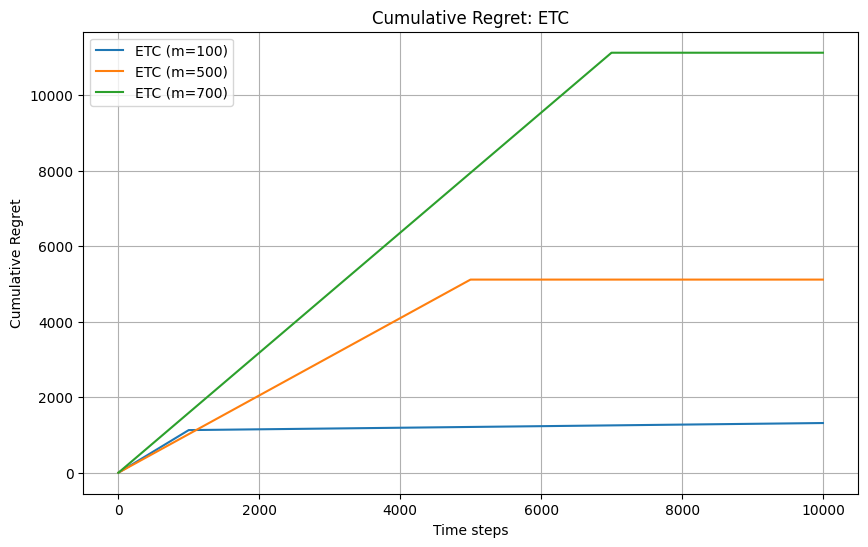

In [4]:
plt.figure(figsize=(10, 6))

# Plot ETC for different m
for m in m_values:
    mean_regret = np.mean(etc_results[m]['regret'], axis=0)
    plt.plot(mean_regret, label=f"ETC (m={m})")



plt.xlabel("Time steps")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret: ETC")
plt.legend()
plt.grid()
plt.show()


## Correct action rates over time

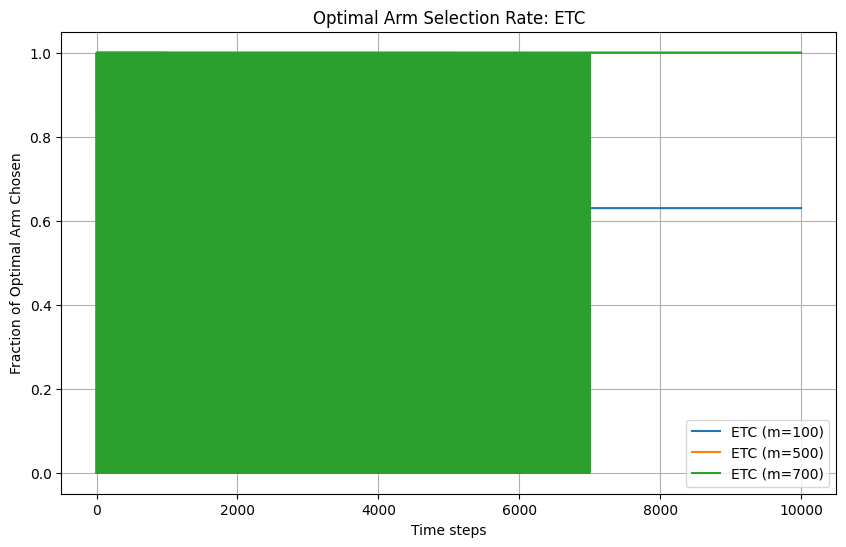

In [5]:
plt.figure(figsize=(10, 6))

# Plot ETC
for m in m_values:
    mean_optimal = np.mean(etc_results[m]['optimal'], axis=0)
    plt.plot(mean_optimal, label=f"ETC (m={m})")

plt.xlabel("Time steps")
plt.ylabel("Fraction of Optimal Arm Chosen")
plt.title("Optimal Arm Selection Rate: ETC")
plt.legend()
plt.grid()
plt.show()


## Actual means vs estimates over time

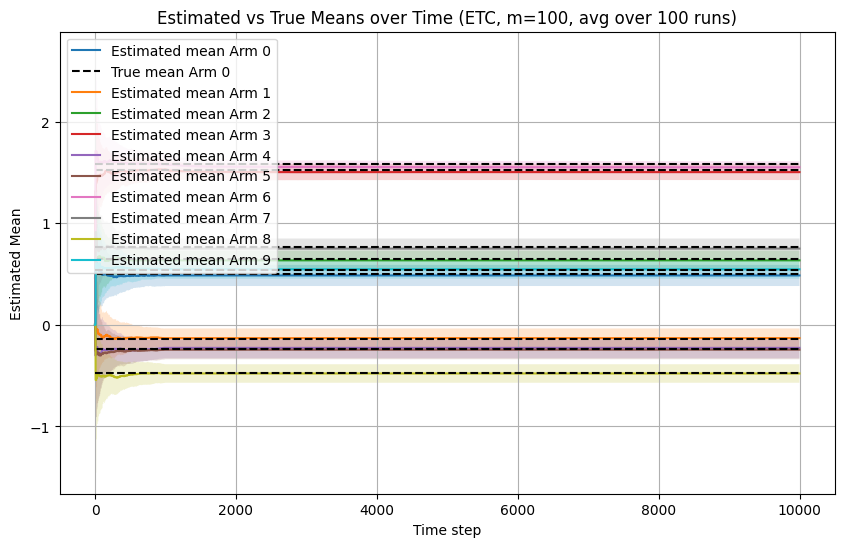

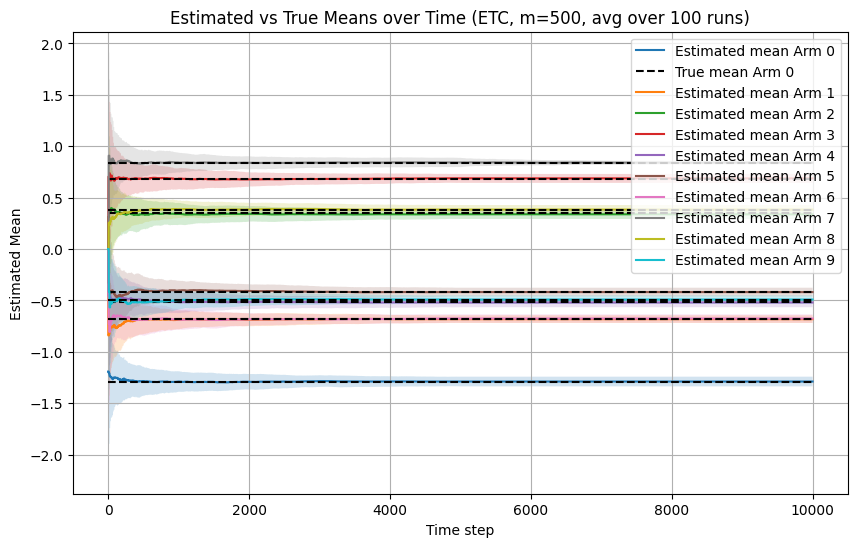

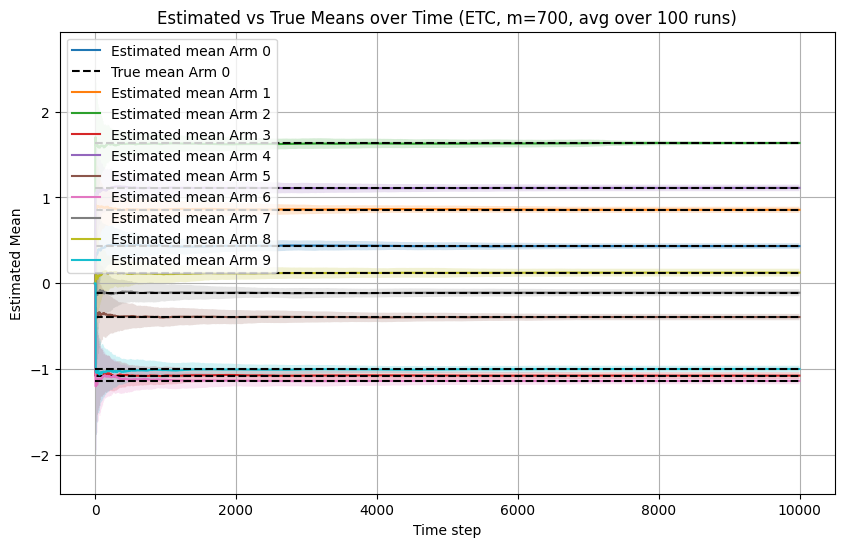

In [6]:
arms_to_plot = list(range(K))  # select arms
time_steps = np.arange(horizon)

for m in m_values:
    est = estimates_over_time[m]  # shape: [num_runs, time, K]

    plt.figure(figsize=(10, 6))
    for arm in arms_to_plot:
        mean_est = est[:, :, arm].mean(axis=0)  # [time]
        std_est = est[:, :, arm].std(axis=0)    # [time]
        
        # Plot mean with confidence band
        plt.plot(time_steps, mean_est, label=f"Estimated mean Arm {arm}")
        plt.fill_between(time_steps, mean_est - std_est, mean_est + std_est, alpha=0.2)

        # Plot true mean
        plt.hlines(actual_means[m][arm], 0, horizon, colors='k', linestyles='--',
                   label=f"True mean Arm {arm}" if arm == 0 else None)

    plt.title(f"Estimated vs True Means over Time (ETC, m={m}, avg over {num_simulations} runs)")
    plt.xlabel("Time step")
    plt.ylabel("Estimated Mean")
    plt.legend()
    plt.grid(True)
    plt.show()
